# Build CNN on MNIST data with following features:
- data augmentation
- advance CNN architecture
- optimized on least model parameters with maximum accuracy

In [1]:
# Import Libraries

from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchsummary import summary
import warnings

# Ignore specific warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

---
---

## Notebook Summary:
1. **Target:** 
    - First Model, Have the right setup and Build foundational CNN architecture for MNIST classification
    - Make the code modular, Include data loader and training & test loop
    - Understand parameter count and model capacity requirements
    - Validate basic model architecture before adding complexity
2. **Results:** 
    - Parameters: 8,856
    - Best Training Accuracy: 98.82
    - Best Test Accuracy: 98.67
3. **Analysis:** 
    - Basic model, shows good learning capability but has room for improvement
    - Lighter model with little or no over-fitting, can be further pushed
    - Small gap between train and test accuracy suggests good generalization
    - Next steps:
        - Introduce batch normalization for better feature scaling
        - Add regularization to prevent potential over-fitting
        - Optimize architecture to reduce parameters


---
---
## Hyperparameters

In [2]:
# Hyperparameters class for easy tuning
class HyperParameters:
    def __init__(self):
        self.num_epochs = 15
        self.batch_size = 128
        self.learning_rate = 0.001
        self.dropout_rate = 0.25
        self.num_classes = 10
        self.momentum = 0.9
        self.random_seed = 193

# Initialize hyperparameters
params = HyperParameters()
print(params.__dict__)

{'num_epochs': 15, 'batch_size': 128, 'learning_rate': 0.001, 'dropout_rate': 0.25, 'num_classes': 10, 'momentum': 0.9, 'random_seed': 193}


## Data Transformations & Tain/Test data loader

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                    #    transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [4]:
# Load MNIST dataset
train = datasets.MNIST('./../data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./../data', train=False, download=True, transform=test_transforms)

In [5]:
# Create data loaders

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(params.random_seed)

if cuda:
    torch.cuda.manual_seed(params.random_seed)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=params.batch_size, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=params.batch_size)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


## CNN Model Architecture 

In [6]:
class TinyCNN(nn.Module):
    def __init__(self):
        super(TinyCNN, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model Summary

In [7]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = TinyCNN().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           1,152
              ReLU-4           [-1, 16, 24, 24]               0
            Conv2d-5            [-1, 8, 22, 22]           1,152
              ReLU-6            [-1, 8, 22, 22]               0
         MaxPool2d-7            [-1, 8, 11, 11]               0
            Conv2d-8           [-1, 16, 11, 11]             128
              ReLU-9           [-1, 16, 11, 11]               0
           Conv2d-10              [-1, 8, 9, 9]           1,152
             ReLU-11              [-1, 8, 9, 9]               0
           Conv2d-12             [-1, 16, 7, 7]           1,152
             ReLU-13             [-1, 16, 7, 7]               0
           Conv2d-14              

## Train & Test Functions

In [8]:
# train

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

In [9]:
# test

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

## Run Model

In [10]:
from torch.optim.lr_scheduler import StepLR

model =  TinyCNN().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = params.num_epochs
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=2.3024742603302 Batch_id=468 Accuracy=15.87: 100%|██████████| 469/469 [00:20<00:00, 22.43it/s]   


Test set: Average loss: 2.3024, Accuracy: 1272/10000 (12.72%)

EPOCH: 1


Loss=0.4996255934238434 Batch_id=468 Accuracy=48.44: 100%|██████████| 469/469 [00:20<00:00, 23.39it/s] 


Test set: Average loss: 0.3320, Accuracy: 9012/10000 (90.12%)

EPOCH: 2


Loss=0.17116843163967133 Batch_id=468 Accuracy=92.75: 100%|██████████| 469/469 [00:19<00:00, 24.42it/s] 


Test set: Average loss: 0.1439, Accuracy: 9537/10000 (95.37%)

EPOCH: 3


Loss=0.19080118834972382 Batch_id=468 Accuracy=95.94: 100%|██████████| 469/469 [00:21<00:00, 21.70it/s] 


Test set: Average loss: 0.0937, Accuracy: 9701/10000 (97.01%)

EPOCH: 4


Loss=0.159903883934021 Batch_id=468 Accuracy=97.04: 100%|██████████| 469/469 [00:19<00:00, 23.85it/s]   


Test set: Average loss: 0.0721, Accuracy: 9765/10000 (97.65%)

EPOCH: 5


Loss=0.021362176164984703 Batch_id=468 Accuracy=97.52: 100%|██████████| 469/469 [00:19<00:00, 24.05it/s]


Test set: Average loss: 0.0674, Accuracy: 9787/10000 (97.87%)

EPOCH: 6


Loss=0.04137054458260536 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:19<00:00, 23.68it/s] 


Test set: Average loss: 0.0613, Accuracy: 9807/10000 (98.07%)

EPOCH: 7


Loss=0.14144204556941986 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:19<00:00, 23.85it/s] 


Test set: Average loss: 0.0568, Accuracy: 9812/10000 (98.12%)

EPOCH: 8


Loss=0.0934847816824913 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:19<00:00, 24.10it/s]   


Test set: Average loss: 0.0529, Accuracy: 9815/10000 (98.15%)

EPOCH: 9


Loss=0.057290878146886826 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:19<00:00, 24.20it/s]


Test set: Average loss: 0.0503, Accuracy: 9848/10000 (98.48%)

EPOCH: 10


Loss=0.019948719069361687 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:19<00:00, 24.05it/s]


Test set: Average loss: 0.0464, Accuracy: 9847/10000 (98.47%)

EPOCH: 11


Loss=0.06272756308317184 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:19<00:00, 23.60it/s]  


Test set: Average loss: 0.0464, Accuracy: 9845/10000 (98.45%)

EPOCH: 12


Loss=0.06174634397029877 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:19<00:00, 23.76it/s]  


Test set: Average loss: 0.0498, Accuracy: 9831/10000 (98.31%)

EPOCH: 13


Loss=0.036704886704683304 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:19<00:00, 24.33it/s] 


Test set: Average loss: 0.0424, Accuracy: 9867/10000 (98.67%)

EPOCH: 14


Loss=0.05560688674449921 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:18<00:00, 25.09it/s]  


Test set: Average loss: 0.0527, Accuracy: 9843/10000 (98.43%)



## Plots

Text(0.5, 1.0, 'Test Accuracy')

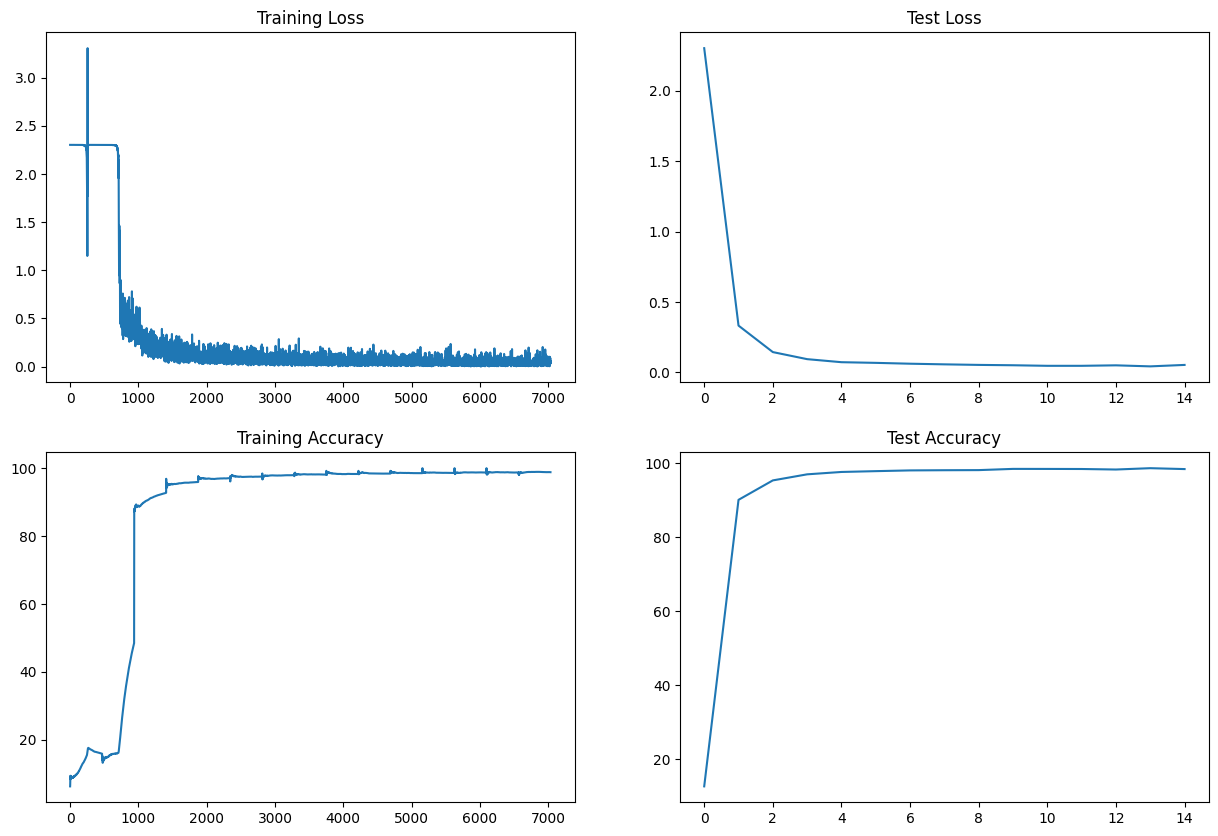

In [11]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [18]:
len(test_acc)

15